# Piotroski F-Score Annual Analysis

This notebook calculates the annual Piotroski F-Score for Brazilian companies using financial statements from CVM and market data from Yahoo Finance.

## 1. Imports and Environment Setup
Load necessary libraries and set up working directories.

In [20]:
# === Imports and Setup ===
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sqlite3
import time
import yfinance as yf
from datetime import datetime
from functools import reduce

if not os.getcwd().endswith("Databases"):
    os.chdir(os.path.join(os.getcwd(), "Databases"))

## 1. Data Collection and Preparation
Load company tickers, connect to the CVM database, and extract key financial statements.
Also includes data cleaning and reshaping for later analysis.

In [2]:
# === Load external data: company info, stock prices, and trading volume ===

# Load list of companies and their tickers
tickers_df = pd.read_excel("companies.xlsx")
tickers_df = tickers_df.dropna(subset=["Ticker"])

# Load historical stock prices
price_data = pd.read_excel("prices.xlsx")

# Load trading volume data
volume_data = pd.read_excel("traded_volume.xlsx")

In [31]:
# === Connect to the CVM database and extract financial data ===

# Connect to the SQLite database containing CVM financial statements
conn = sqlite3.connect('dados_cvm.db')

def load_financial_table(table_name):
    """
    Load a specific financial statement table from the CVM database.

    Parameters:
        table_name (str): Name of the database table (e.g., 'dfp_dre_con').

    Returns:
        pd.DataFrame: Filtered DataFrame containing relevant financial data.
    """
    query = f"""
        SELECT 
            CD_CVM, DENOM_CIA, DT_FIM_EXERC,
            CD_CONTA, DS_CONTA, VL_CONTA, ORDEM_EXERC
        FROM {table_name}
        WHERE ORDEM_EXERC = 'ÚLTIMO'
    """
    return pd.read_sql(query, conn)

# Load financial statement tables
income_statement = load_financial_table("dfp_dre_con")          # DRE
balance_sheet_assets = load_financial_table("dfp_bpa_con")      # BPA
balance_sheet_liabilities = load_financial_table("dfp_bpp_con") # BPP
cash_flow = load_financial_table("dfp_dfc_mi_con")              # DFC

# Load share capital information
share_data = pd.read_sql("""
    SELECT 
        Nome_Companhia,
        Ano,
        Quantidade_Acoes_Ordinarias,
        Quantidade_Acoes_Preferenciais
    FROM fre_capital_social
""", conn)

# Close the database connection
conn.close()

In [32]:
# === Define the accounts required for Piotroski F-Score calculation ===

# Income Statement (DRE)
dre_accounts = {
    "3.01": "Revenue",
    "3.03": "Gross Profit",
    "3.11": "Net Income"
}

# Cash Flow Statement (DFC)
dfc_accounts = {
    "6.01": "Operating Cash Flow"
}

# Balance Sheet - Assets (BPA)
bpa_accounts = {
    "1": "Total Assets",
    "1.01": "Current Assets"
}

# Balance Sheet - Liabilities (BPP)
bpp_accounts = {
    "2.01": "Current Liabilities",
    "2.01.04": "Short-Term Debt",
    "2.02.01": "Long-Term Debt"
}

In [33]:
def filter_and_pivot_accounts(df, account_mapping, id_col="CD_CONTA"):
    """
    Filters and pivots a financial statement DataFrame based on specified accounts.

    Parameters:
        df (pd.DataFrame): Raw financial data from CVM.
        account_mapping (dict): Dictionary mapping account codes to descriptive names.
        id_col (str): Column containing account codes.

    Returns:
        pd.DataFrame: Pivoted DataFrame with company, year, and selected accounts.
    """
    filtered_df = df[df[id_col].isin(account_mapping.keys())].copy()
    filtered_df["VL_CONTA"] = pd.to_numeric(filtered_df["VL_CONTA"], errors="coerce")
    filtered_df["account_name"] = filtered_df[id_col].map(account_mapping)
    filtered_df["year"] = pd.to_datetime(filtered_df["DT_FIM_EXERC"]).dt.year
    filtered_df.rename(columns={"DENOM_CIA": "company"}, inplace=True)

    pivot_df = filtered_df.pivot_table(
        index=["CD_CVM", "company", "year"],
        columns="account_name",
        values="VL_CONTA"
    ).reset_index()

    return pivot_df

In [34]:
# === Apply filtering to select relevant financial accounts from each statement ===

income_selected = filter_and_pivot_accounts(income_statement, dre_accounts)
cashflow_selected = filter_and_pivot_accounts(cash_flow, dfc_accounts)
assets_selected = filter_and_pivot_accounts(balance_sheet_assets, bpa_accounts)
liabilities_selected = filter_and_pivot_accounts(balance_sheet_liabilities, bpp_accounts)

In [35]:
# === Merge all selected financial data into a single DataFrame ===

# List of selected financial DataFrames to combine
financial_dfs = [income_selected, cashflow_selected, assets_selected, liabilities_selected]

# Merge on company code, company name, and year using outer join
base_financials = reduce(
    lambda left, right: pd.merge(left, right, on=["CD_CVM", "company", "year"], how="outer"),
    financial_dfs
)

In [36]:
# === Preprocess share capital data ===

# Replace missing values with 0 for ordinary and preferred shares
share_data['Quantidade_Acoes_Ordinarias'] = share_data['Quantidade_Acoes_Ordinarias'].fillna(0)
share_data['Quantidade_Acoes_Preferenciais'] = share_data['Quantidade_Acoes_Preferenciais'].fillna(0)

# Calculate total shares outstanding
share_data['Total_Shares'] = (
    share_data['Quantidade_Acoes_Ordinarias'] + share_data['Quantidade_Acoes_Preferenciais']
)

# Keep only valid rows with non-zero shares
share_data = share_data[share_data['Total_Shares'] > 0]

# Keep only the latest record for each company-year pair
share_data = (
    share_data
    .sort_values(['Nome_Companhia', 'ANO'])
    .drop_duplicates(subset=['Nome_Companhia', 'ANO'], keep='last')
)

# Rename columns for consistency
share_data = share_data.rename(columns={"Nome_Companhia": "company", "ANO": "year"})

In [37]:
# === Merge share capital data with the base financial dataset ===

final_df = pd.merge(
    base_financials,
    share_data[["company", "year", "Total_Shares"]],
    on=["company", "year"],
    how="left"
)

## 2. Piotroski F-Score Calculation
Apply the 9 accounting-based criteria to compute the Piotroski F-Score for each company-year.

In [38]:
def calculate_f_score(financial_df, tickers_df):
    """
    Calculates the Piotroski F-Score for each company-year based on financial data.

    Parameters:
        financial_df (pd.DataFrame): Merged financial dataset.
        tickers_df (pd.DataFrame): DataFrame containing company names and tickers.

    Returns:
        pd.DataFrame: A DataFrame with company name, ticker, year, each score component, and final F-Score.
    """
    df = financial_df.copy()
    df = df.sort_values(['company', 'year'])

    # === Profitability criteria ===
    df["ROA"] = df["Net Income"] / df["Total Assets"]
    df["Δ ROA"] = df.groupby("company")["ROA"].diff()
    df["ROA (+)"] = (df["ROA"] > 0).astype(int)
    df["OCF (+)"] = (df["Operating Cash Flow"] > 0).astype(int)
    df["Δ ROA (+)"] = (df["Δ ROA"] > 0).astype(int)
    df["OCF > Net Income"] = (df["Operating Cash Flow"] > df["Net Income"]).astype(int)

    # === Leverage and Liquidity ===
    df["Total Debt"] = df["Short-Term Debt"].fillna(0) + df["Long-Term Debt"].fillna(0)
    df["Debt / Assets"] = df["Total Debt"] / df["Total Assets"]
    df["Δ Debt / Assets"] = -df.groupby("company")["Debt / Assets"].diff()
    df["Δ Debt / Assets (-)"] = (df["Δ Debt / Assets"] > 0).astype(int)

    df["Current Ratio"] = df["Current Assets"] / df["Current Liabilities"]
    df["Δ Current Ratio"] = df.groupby("company")["Current Ratio"].diff()
    df["Δ Current Ratio (+)"] = (df["Δ Current Ratio"] > 0).astype(int)

    # === Operating Efficiency ===
    df["Gross Margin"] = df["Gross Profit"] / df["Revenue"]
    df["Δ Gross Margin"] = df.groupby("company")["Gross Margin"].diff()
    df["Δ Gross Margin (+)"] = (df["Δ Gross Margin"] > 0).astype(int)

    df["Asset Turnover"] = df["Revenue"] / df["Total Assets"]
    df["Δ Asset Turnover"] = df.groupby("company")["Asset Turnover"].diff()
    df["Δ Asset Turnover (+)"] = (df["Δ Asset Turnover"] > 0).astype(int)

    # === Share Issuance ===
    df["Δ Shares"] = df.groupby("company")["Total_Shares"].diff()
    df["No New Shares Issued"] = (df["Δ Shares"] <= 0).astype(int)

    # === F-Score Aggregation ===
    df["f_score"] = (
        df["ROA (+)"] +
        df["OCF (+)"] +
        df["Δ ROA (+)"] +
        df["OCF > Net Income"] +
        df["Δ Debt / Assets (-)"] +
        df["Δ Current Ratio (+)"] +
        df["Δ Gross Margin (+)"] +
        df["Δ Asset Turnover (+)"] +
        df["No New Shares Issued"]
    )

    # === Merge with ticker data ===
    tickers_df = tickers_df.rename(columns={"empresa": "company", "Ticker": "ticker"})
    df = df.merge(tickers_df, on="company", how="left")

    return df[[
        "company", "ticker", "year",
        "ROA (+)", "OCF (+)", "Δ ROA (+)", "OCF > Net Income",
        "Δ Debt / Assets (-)", "Δ Current Ratio (+)",
        "Δ Gross Margin (+)", "Δ Asset Turnover (+)",
        "No New Shares Issued", "f_score"
    ]]

In [39]:
# === Calculate Piotroski F-Score and filter results ===

f_score_results = calculate_f_score(final_df, tickers_df)

# Drop rows where ticker is missing (likely unmatched companies)
f_score_results = f_score_results.dropna(subset=['ticker'])

# Show companies with perfect F-Score (9) in the most recent year (e.g., 2023)
f_score_results.query("year == 2018 and f_score == 8").sort_values(by="f_score", ascending=False)

,company,ticker,year,ROA (+),OCF (+),Δ ROA (+),OCF > Net Income,Δ Debt / Assets (-),Δ Current Ratio (+),Δ Gross Margin (+),Δ Asset Turnover (+),No New Shares Issued,f_score
47,ALIANSCE SHOPPING CENTERS S.A.,ALOS3,2018,1,1,1,1,0,1,1,1,1,8
196,ATACADÃO S.A.,CRFB3,2018,1,1,1,1,1,1,1,0,1,8
276,"B3 S.A. - BRASIL, BOLSA, BALCÃO",B3SA3,2018,1,1,1,1,1,1,0,1,1,8
840,CIA INDUSTRIAL CATAGUASES,CATA4,2018,0,1,1,1,1,1,1,1,1,8
1079,CONSTRUTORA TENDA S.A.,TEND3,2018,1,1,1,1,0,1,1,1,1,8
1121,CPFL ENERGIA S.A.,CPFE3,2018,1,1,1,0,1,1,1,1,1,8
1130,CPFL ENERGIAS RENOVÁVEIS S.A.,CPFE3,2018,1,1,1,1,1,1,1,1,0,8
1139,CPFL GERACAO DE ENERGIA S.A.,CPFE3,2018,1,1,1,1,1,0,1,1,1,8
1209,CYRELA BRAZIL REALTY S.A.EMPREEND E PART,CYRE3,2018,1,1,1,1,1,1,0,1,1,8
1262,DIMED S.A. DISTRIBUIDORA DE MEDICAMENTOS,PNVL3,2018,1,1,1,1,1,0,1,1,1,8


## 3. Results and Visualization
Display the resulting scores, perform summary statistics, and plot the distribution or rankings.

In [83]:
def simulate_fscore_portfolio(f_score_results, price_data, volume_data, min_avg_volume, target_fscore=9, start_year=None):
    """
    Simulates an annual investment strategy based on the Piotroski F-Score.

    Parameters:
        f_score_results (pd.DataFrame): Contains ['year', 'ticker', 'f_score']
        price_data (pd.DataFrame): Contains ['Ticker', 'Data', 'Cotacao'] (stock prices).
        volume_data (pd.DataFrame): Contains ['Ticker', 'Data', 'Volume'] (trading volumes).
        min_avg_volume (float): Minimum average trading volume required per year.
        target_fscore (int): Target F-Score to filter stocks (default is 9).
        start_year (int, optional): Year when backtest should start (inclusive).
    
    Returns:
        pd.DataFrame: Daily and cumulative returns of the portfolio and IBOV index, year by year.
    """

    # Parse dates
    price_data['Data'] = pd.to_datetime(price_data['Data'])
    volume_data['Data'] = pd.to_datetime(volume_data['Data'])

    # Filter by average volume
    volume_data['Year'] = volume_data['Data'].dt.year
    avg_volume = volume_data.groupby(['Ticker', 'Year'])['Volume'].mean().reset_index()
    avg_volume = avg_volume[avg_volume['Volume'] >= min_avg_volume]

    # Filter F-score and years
    selected = f_score_results[f_score_results['f_score'] == target_fscore]
    if start_year:
        selected = selected[selected["year"] >= start_year - 1]

    valid_stocks = pd.merge(selected, avg_volume, left_on=['ticker', 'year'], right_on=['Ticker', 'Year'])

    # === Check for missing years ===
    expected_years = set(selected['year'].unique())
    available_years = set(valid_stocks['year'].unique())
    missing_years = expected_years - available_years

    if missing_years:
        missing_list = ', '.join(str(y + 1) for y in sorted(missing_years))  # year+1 = year of portfolio
        print(f"⚠️ Portfolio for F-Score {target_fscore} skipped — no eligible stocks in year(s): {missing_list}")
        return pd.DataFrame()  # abort this F-score

    results = []
    cumulative_portfolio = 1
    cumulative_ibov = 1

    for year in sorted(valid_stocks['year'].unique()):
        tickers = valid_stocks[valid_stocks['year'] == year]['ticker'].unique()
        if len(tickers) == 0:
            continue

        start = pd.Timestamp(f"{year + 1}-01-01")
        end = pd.Timestamp(f"{year + 1}-12-31")

        year_prices = price_data[
            (price_data['Ticker'].isin(tickers)) &
            (price_data['Data'] >= start) &
            (price_data['Data'] <= end)
        ]

        if year_prices.empty:
            continue

        pivot_prices = year_prices.pivot(index="Data", columns="Ticker", values="Cotacao").dropna(how='all')
        if pivot_prices.empty or pivot_prices.iloc[0].isnull().all():
            continue

        pivot_prices = pivot_prices / pivot_prices.iloc[0]
        daily_returns = pivot_prices.pct_change(fill_method=None).dropna()
        daily_returns["Daily Return"] = daily_returns.mean(axis=1)
        daily_returns["Cumulative Return"] = (1 + daily_returns["Daily Return"]).cumprod() * cumulative_portfolio
        cumulative_portfolio = daily_returns["Cumulative Return"].iloc[-1]

        try:
            ibov_data = yf.download("^BVSP", start=start.strftime("%Y-%m-%d"), end=end.strftime("%Y-%m-%d"),
                                    progress=False, auto_adjust=False)["Adj Close"]
            time.sleep(1)
        except Exception as e:
            print(f"Failed to download IBOVESPA data for {year + 1}: {e}")
            continue

        if ibov_data.empty:
            print(f"No IBOV data available for {year + 1}")
            continue

        ibov_data = ibov_data.sort_index()
        ibov_aligned = ibov_data.reindex(daily_returns.index)
        ibov_daily = ibov_aligned.pct_change(fill_method=None).fillna(0)
        ibov_cum = (1 + ibov_daily).cumprod() * cumulative_ibov
        cumulative_ibov = ibov_cum.iloc[-1]

        df_result = daily_returns[["Daily Return", "Cumulative Return"]].copy()
        df_result["Date"] = df_result.index
        df_result["Base Year"] = year
        df_result["Assets"] = ', '.join(tickers)
        df_result["IBOV Points"] = ibov_aligned.values
        df_result["IBOV Daily Return"] = ibov_daily.values
        df_result["IBOV Cumulative Return"] = ibov_cum.values

        results.append(df_result)

    if not results:
        raise ValueError("No valid portfolios were processed.")

    return pd.concat(results).reset_index(drop=True)[[
        "Date", "Base Year", "Assets",
        "Daily Return", "Cumulative Return",
        "IBOV Points", "IBOV Daily Return", "IBOV Cumulative Return"
    ]]

In [90]:
def backtest_fscore_levels(f_score_results, price_data, volume_data, min_avg_volume, fscore_list=[3, 5, 8, 9], start_year=None):
    """
    Perform a comparative backtest of portfolios based on different F-Score levels.

    Parameters:
        f_score_results (pd.DataFrame): Contains ['year', 'ticker', 'f_score']
        price_data (pd.DataFrame): Contains ['Ticker', 'Data', 'Cotacao']
        volume_data (pd.DataFrame): Contains ['Ticker', 'Data', 'Volume']
        min_avg_volume (float): Minimum required average annual trading volume
        fscore_list (list): F-Scores to backtest (e.g., [3, 5, 8, 9])
        start_year (int, optional): Skip years prior to this year (inclusive) in portfolio formation
    """

    def format_quarter(x, pos):
        date = mdates.num2date(x)
        year = str(date.year)[-2:]
        quarter = (date.month - 1) // 3 + 1
        return f"{quarter}Q{year}"

    fig, ax = plt.subplots(figsize=(14, 7))
    ibov_plotted = False

    for score in fscore_list:
        try:
            df_result = simulate_fscore_portfolio(
                f_score_results,
                price_data,
                volume_data,
                min_avg_volume=min_avg_volume,
                target_fscore=score,
                start_year=start_year  # ✅ novo parâmetro
            )

            df_result = df_result.drop_duplicates("Date").set_index("Date").sort_index()

            if start_year:
                df_result = df_result[df_result.index >= pd.Timestamp(f"{start_year}-01-01")]
            
            if df_result.empty or df_result["Cumulative Return"].dropna().shape[0] < 2:
                print(f"⚠️ No valid portfolio data for F-Score {score} — skipping.")
                continue
                
            returns = df_result[["Cumulative Return"]].copy()
            x_vals = returns.index
            y_vals = returns["Cumulative Return"]

            ax.plot(x_vals, y_vals, label=f"F-Score {score}")
            ax.annotate(f"{y_vals.iloc[-1]:.2f}x",
                        xy=(x_vals[-1], y_vals.iloc[-1]),
                        xytext=(5, 0), textcoords="offset points",
                        fontweight="bold", fontsize=10, va="center", color="black")

            # Plot IBOV once
            if not ibov_plotted and "IBOV Cumulative Return" in df_result.columns:
                ibov_ret = df_result[["IBOV Cumulative Return"]].copy()
                ibov_ret /= ibov_ret.iloc[0]
                x_ibov = ibov_ret.index
                y_ibov = ibov_ret["IBOV Cumulative Return"]

                ax.plot(x_ibov, y_ibov, label="IBOV", linestyle="--", linewidth=2, color="black")
                ax.annotate(f"{y_ibov.iloc[-1]:.2f}x",
                            xy=(x_ibov[-1], y_ibov.iloc[-1]),
                            xytext=(5, 0), textcoords="offset points",
                            fontweight="bold", fontsize=10, va="center", color="black")
                ibov_plotted = True

        except Exception as e:
            continue

    # Highlight COVID-19 crash
    pandemic_start = datetime(2020, 2, 20)
    pandemic_end = datetime(2020, 4, 10)
    pandemic_mid = pandemic_start + (pandemic_end - pandemic_start) / 2

    ax.axvspan(pandemic_start, pandemic_end, color='lightgray', alpha=0.5)
    ax.text(pandemic_mid, ax.get_ylim()[1] * 0.90,
            "COVID-19", color="red", fontsize=8, fontweight="bold", ha="center")

    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    ax.xaxis.set_major_formatter(plt.FuncFormatter(format_quarter))
    plt.setp(ax.get_xticklabels(), rotation=0, fontsize=9)
    plt.setp(ax.get_yticklabels(), fontsize=9)

    ax.set_title("F-Score Backtest", fontsize=14, fontweight="bold")
    ax.set_ylabel("Cumulative Return (Multiplier)", fontsize=9)
    ax.grid(axis="y", linestyle="--", alpha=0.6)
    ax.legend()
    fig.tight_layout()
    plt.show()

In [84]:
# === Simulate a portfolio using the Piotroski F-Score strategy ===

# This function builds an equal-weighted portfolio each year,
# selecting only stocks that meet the specified F-Score condition.
# The portfolio is rebalanced annually based on available financials
# and filtered by a minimum average trading volume.

# Parameters:
# - f_score_results: Preprocessed DataFrame with F-Scores by company and year
# - price_data: Historical stock prices (must include 'Ticker', 'Data', 'Cotacao')
# - volume_data: Historical daily trading volumes
# - min_avg_volume: Only stocks with average annual volume >= 1M will be considered
# - target_fscore: Only stocks with F-Score == 9 will be selected for the portfolio
# - start_year: The portfolio will start from 2019 (using financials from 2018)

df_portfolio = simulate_fscore_portfolio(
    f_score_results,
    price_data,
    volume_data,
    min_avg_volume=1_000_000,   # Liquidity filter (1M BRL/year)
    target_fscore=8,            # Only the highest-quality companies (F-Score = 8)
    start_year=2019             # First portfolio formed in 2019 (based on 2018 data)
)

# The result is a DataFrame with daily and cumulative returns of the simulated portfolio
# along with IBOVESPA data for benchmark comparison.
df_portfolio.tail()

Ticker,Date,Base Year,Assets,Daily Return,Cumulative Return,IBOV Points,IBOV Daily Return,IBOV Cumulative Return
1558,2025-04-23,2024,"ALPA4, ANIM3, BBDC3, CEAB3, COGN3, CPFE3, FLRY...",0.005295,3.210846,132216.0,0.013429,1.560934
1559,2025-04-24,2024,"ALPA4, ANIM3, BBDC3, CEAB3, COGN3, CPFE3, FLRY...",0.031074,3.310621,134580.0,0.017880,1.588843
1560,2025-04-25,2024,"ALPA4, ANIM3, BBDC3, CEAB3, COGN3, CPFE3, FLRY...",0.002518,3.318958,134739.0,0.001181,1.590720
1561,2025-04-28,2024,"ALPA4, ANIM3, BBDC3, CEAB3, COGN3, CPFE3, FLRY...",0.000733,3.321389,135016.0,0.002056,1.593991
1562,2025-04-29,2024,"ALPA4, ANIM3, BBDC3, CEAB3, COGN3, CPFE3, FLRY...",-0.001916,3.315026,135093.0,0.000570,1.594900


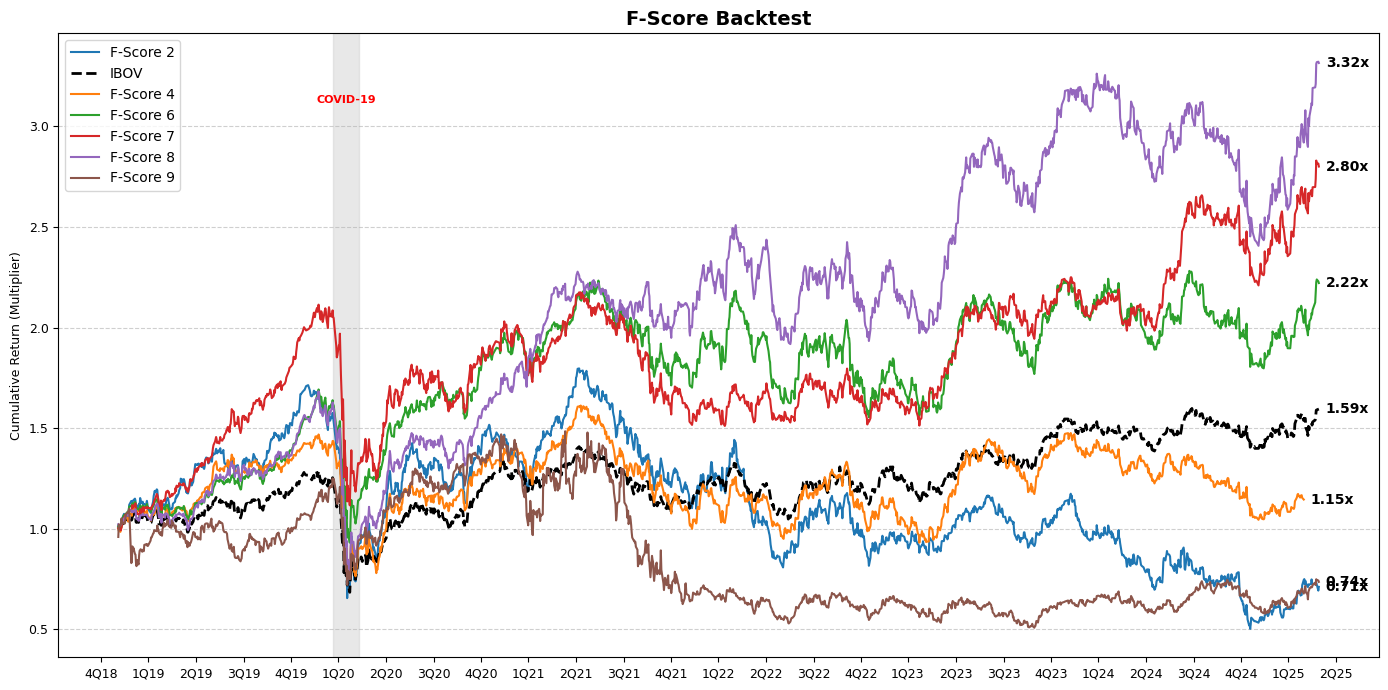

In [91]:
# === Perform backtest for all F-Score levels (0 to 9) against IBOVESPA ===

# This runs a comparative simulation for each F-Score level, from 0 to 9.
# For each level, the function:
# - Selects all companies with that exact F-Score in a given year
# - Builds a portfolio for the following year using those companies
# - Applies a liquidity filter (average trading volume >= R$1,000,000/year)
# - Compares the cumulative return of each portfolio to the IBOVESPA (^BVSP)

# Notes:
# - The backtest starts in 2019, meaning it uses financial data from 2018
# - If any F-Score level does not have valid stocks in any required year,
#   the entire series for that level will be skipped (with a warning)

backtest_fscore_levels(
    f_score_results,
    price_data,
    volume_data,
    min_avg_volume=1_000_000,     # Liquidity constraint
    fscore_list=[2, 4, 6, 7, 8, 9],  # Evaluate every F-Score from 0 to 9
    start_year=2019               # Portfolios start from 2019 (data from 2018)
)